## Given a message, detect if it's Spam or Ham

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud # visualize most common words from each class

#### Use kaggle dataset for training:- https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [2]:
!wget https://lazyprogrammer.me/course_files/spam.csv

--2023-06-20 11:59:08--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 2606:4700:3031::6815:17d2, 2606:4700:3030::ac43:d5a6, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|2606:4700:3031::6815:17d2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: 'spam.csv'

spam.csv            100%[===================>] 491.86K   488KB/s    in 1.0s    

2023-06-20 11:59:11 (488 KB/s) - 'spam.csv' saved [503663/503663]



#### While reading CSV, use encode to remove invalid characters

In [3]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


#### Remove unnecessary columns from the dataframe

In [5]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1)

In [6]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Changing column names to something better

In [7]:
df.columns = ["labels", "data"]

In [8]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


<AxesSubplot:>

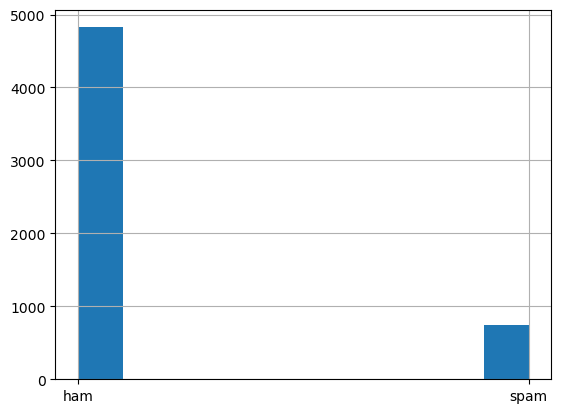

In [9]:
df['labels'].hist()

*Above histogram clearly shows that the classes are imbalanced.
Accuracy won't be a good measure to verify whether the model is good or not.*

#### Turn text into binary labels for ham as 0 and spam as 1

In [27]:
df["b_labels"] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].to_numpy()
Y

array([0, 0, 1, ..., 0, 0, 0])

In [11]:
df_train, df_test, Ytrain, Ytest = train_test_split(df['data'], Y, test_size=0.33)

#### We can try multiple ways of calculation features 

In [12]:
# featurizer = TfidfVectorizer(decode_error='ignore')
featurizer = CountVectorizer(decode_error='ignore')
Xtrain = featurizer.fit_transform(df_train)
Xtest = featurizer.transform(df_test)

In [13]:
Xtrain

<3733x7033 sparse matrix of type '<class 'numpy.int64'>'
	with 49577 stored elements in Compressed Sparse Row format>

### Create the model, train it, print scores

In [14]:
model = MultinomialNB()
model.fit(Xtrain, Ytrain)
print("train acc:", model.score(Xtrain, Ytrain))
print("test acc:", model.score(Xtest, Ytest))

train acc: 0.994106616662202
test acc: 0.9853181076672104


#### F1 and AUC Scores are great measures with respect to class imbalances

In [15]:
# F1 SCORE
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)
print("train F1:", f1_score(Ytrain, Ptrain))
print("test F1:", f1_score(Ytest, Ptest))

train F1: 0.9783464566929134
test F1: 0.9403973509933774


In [16]:
# AUC SCORE
Prob_train = model.predict_proba(Xtrain)[:,1]
Prob_test = model.predict_proba(Xtest)[:,1]
print("train AUC:", roc_auc_score(Ytrain, Prob_train))
print("test AUC:", roc_auc_score(Ytest, Prob_test))

train AUC: 0.9915965878665463
test AUC: 0.9791393861004067


In [17]:
cm = confusion_matrix(Ytrain, Ptrain)
cm

array([[3214,    5],
       [  17,  497]])

***Plotting Confusion Matrix using Scikit Learn***

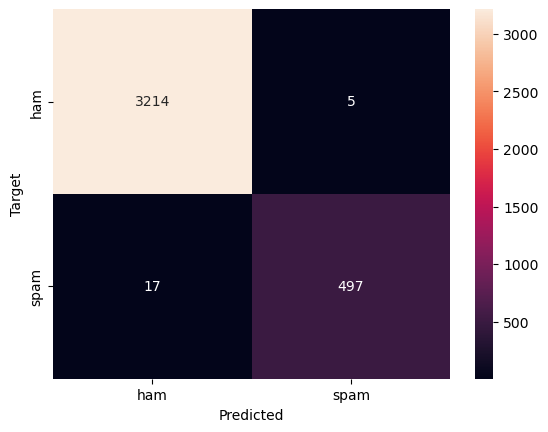

In [18]:
def plot_cm(cm):
    classes = ['ham', 'spam']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Target')
    
plot_cm(cm)

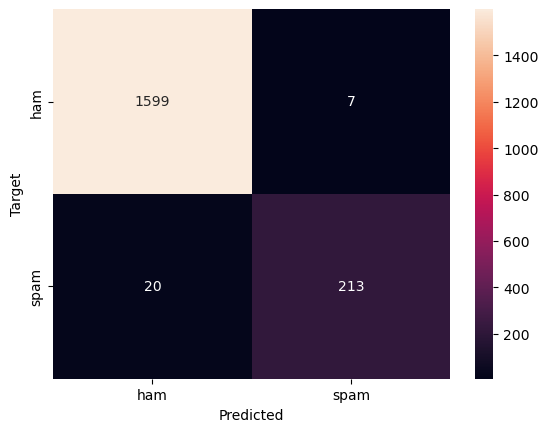

In [19]:
cm_test = confusion_matrix(Ytest, Ptest)
plot_cm(cm_test)

#### Visualizing the data using WordCloud

In [20]:
def visualize(label):
    words = ''
    for msg in df[df['labels'] == label]['data']:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=400).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

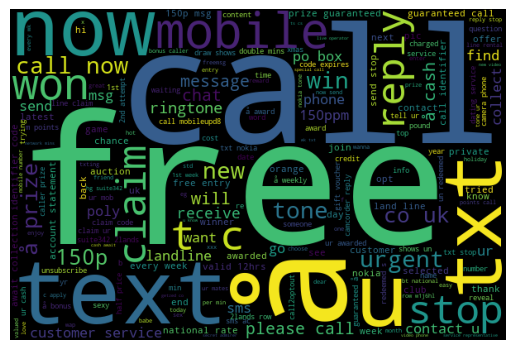

In [21]:
visualize('spam')

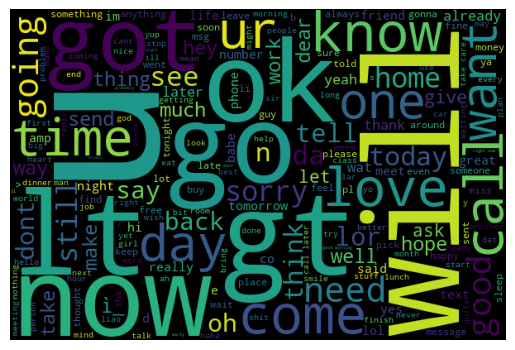

In [22]:
visualize('ham')

#### Creating a new column "predictions" to compare wrong results

In [23]:
X = featurizer.transform(df['data'])
df['predictions'] = model.predict(X)

***Things that are spam but not predicted***

In [24]:
sneaky_spam = df[(df['predictions'] == 0) & (df['b_labels'] == 1)]['data']
for msg in sneaky_spam:
    print(msg)

FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv
Did you hear about the new \Divorce Barbie\"? It comes with all of Ken's stuff!"
SMS. ac sun0819 posts HELLO:\You seem cool
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
Filthy stories and GIRLS waiting for your
Can U get 2 phone NOW? I wanna chat 2 set up meet Call me NOW on 09096102316 U can cum here 2moro Luv JANE xx Callså£1/minmoremobsEMSPOBox45PO139WA
For sale - arsenal dartboard. Good condition but no doubles or trebles!
Would you like to see my XXX pics they are so hot they were nearly banned in the uk!
Hi ya babe x u 4goten bout me?' scammers getting smart..Though this is a regular vodafone no, if you respond you get further prem rate msg/sub

***Things that are not spam but predicted***

*Maybe some of the rows are mislabeled in our data* 

In [25]:
not_actually_spam = df[(df['predictions'] == 1) & (df['b_labels'] == 0)]['data']
for msg in not_actually_spam:
    print(msg)

Waiting for your call.
Hey...Great deal...Farm tour 9am to 5pm $95/pax, $50 deposit by 16 May
Total video converter free download type this in google search:)
Unlimited texts. Limited minutes.
Mathews or tait or edwards or anderson
Update your face book status frequently :)
Gettin rdy to ship comp
Have you laid your airtel line to rest?
Received, understood n acted upon!
I liked the new mobile
I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
Nokia phone is lovly..


In [30]:
df['data']

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: data, Length: 5572, dtype: object